<a href="https://colab.research.google.com/github/Whoami666/HSE_Lab/blob/main/clean_models/SMOTE_schiz_models_random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd drive
%cd MyDrive
%cd shiz

/content/drive
/content/drive/MyDrive
/content/drive/MyDrive/shiz


In [ ]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 KB 10.8 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

from skopt import BayesSearchCV
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import KFold

from imblearn.over_sampling import SMOTE

In [ ]:
scoring = ['recall', 'accuracy', 'f1', 'roc_auc']

In [ ]:
df = pd.read_excel('df_standard_cleaned_21feb.xlsx') 
df1d = pd.read_excel('df_standard_only1dfeatures.xlsx')

df = df.set_index('ID')
df1d = df1d.set_index('ID')
df.head(1)

,sex,tds,chroma_cens_avg,chroma_cens_std,chroma_cqt_avg,chroma_cqt_std,chroma_stft_avg,chroma_stft_std,melspectrogram_avg,melspectrogram_std,...,spectral_flatness_std,spectral_rolloff_avg,spectral_rolloff_std,tempogram_avg,tempogram_std,tonnetz_avg,tonnetz_std,zero_crossing_rate_avg,zero_crossing_rate_std,tds_binary
ID,,,,,,,,,,,,,,,,,,,,,
PD-003,1,0,0.685706,0.428088,0.425039,0.296394,0.339246,0.434412,0.327867,0.348849,...,0.31499,0.397736,0.254215,0.747885,0.719312,0.691479,0.329593,0.197304,0.281692,0


**Non-binary**

All features

In [ ]:
X = df.drop(['tds', 'tds_binary'], axis=1)
y = df.tds # Target variable

oversample = SMOTE(k_neighbors=2)
X, y = oversample.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=16)

In [ ]:
warnings.filterwarnings('ignore')

opt = BayesSearchCV(
    RandomForestClassifier(),
    {
        'n_estimators':  (100, 1000),
        'max_depth': (10, 100),
        'min_samples_split': np.linspace(0.0001, 1, 10),
        'min_samples_leaf': np.linspace(0.0001, 0.5, 10),
    },
    n_iter=32,
    cv=3
)

opt.fit(X_train, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))
print("best_params: %s" % opt.best_params_)

val. score: 0.9481481481481482
test score: 0.9777777777777777
best_params: OrderedDict([('max_depth', 100), ('min_samples_leaf', 0.0001), ('min_samples_split', 0.0001), ('n_estimators', 1000)])


In [ ]:
rfc1 = RandomForestClassifier(n_estimators = opt.best_params_['n_estimators'], 
                             max_depth = opt.best_params_['max_depth'],
                             min_samples_split = opt.best_params_['min_samples_split'],
                             min_samples_leaf = opt.best_params_['min_samples_leaf'])
rfc1.fit(X_train, y_train)
y_pred = rfc1.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        55
           1       0.95      1.00      0.98        60
           2       1.00      1.00      1.00        65

    accuracy                           0.98       180
   macro avg       0.98      0.98      0.98       180
weighted avg       0.98      0.98      0.98       180



In [ ]:
kf = KFold(n_splits=10)

crossval_accuracy = cross_val_score(rfc1, X, y, scoring='accuracy', cv = kf)
mean_score = crossval_accuracy.mean()
std_score = crossval_accuracy.std()
print('accuracy', mean_score, '±', std_score)

crossval_recall = cross_val_score(rfc1, X, y, scoring='recall_macro', cv = kf)
mean_score = crossval_recall.mean()
std_score = crossval_recall.std()
print('recall', mean_score, '±', std_score)

accuracy 0.9733333333333334 ± 0.03413842554608271
recall 0.931685317224533 ± 0.15684747676225122


Text(0.5, 0, 'Random Forest Feature Importance')

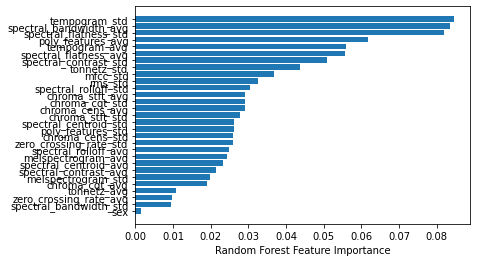

In [ ]:
sorted_idx = rfc1.feature_importances_.argsort()
feature_names = [f"feature {i}" for i in range(X.shape[1])]
plt.barh(X.columns[sorted_idx], rfc1.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")


Only 1D features

In [ ]:
X = df1d.drop(['tds', 'tds_binary'], axis=1)
y = df1d.tds # Target variable

oversample = SMOTE(k_neighbors=2)
X, y = oversample.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=16)

In [ ]:
warnings.filterwarnings('ignore')

opt = BayesSearchCV(
    RandomForestClassifier(),
    {
        'n_estimators':  (100, 1000),
        'max_depth': (10, 100),
        'min_samples_split': np.linspace(0.0001, 1, 10),
        'min_samples_leaf': np.linspace(0.0001, 0.5, 10),
    },
    n_iter=32,
    scoring='f1_macro',
    cv=3
)

opt.fit(X_train, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))
print("best_params: %s" % opt.best_params_)

val. score: 0.8822362831413608
test score: 0.9531477784302211
best_params: OrderedDict([('max_depth', 10), ('min_samples_leaf', 0.0001), ('min_samples_split', 0.0001), ('n_estimators', 1000)])


In [ ]:
rfc2 = RandomForestClassifier(n_estimators = opt.best_params_['n_estimators'], 
                             max_depth = opt.best_params_['max_depth'],
                             min_samples_split = opt.best_params_['min_samples_split'],
                             min_samples_leaf = opt.best_params_['min_samples_leaf'])
rfc2.fit(X_train, y_train)
y_pred = rfc2.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.85      0.91        55
           1       0.89      0.98      0.94        60
           2       0.98      1.00      0.99        65

    accuracy                           0.95       180
   macro avg       0.95      0.95      0.95       180
weighted avg       0.95      0.95      0.95       180



In [ ]:
kf = KFold(n_splits=10)

crossval_accuracy = cross_val_score(rfc2, X, y, scoring='accuracy', cv = kf)
mean_score = crossval_accuracy.mean()
std_score = crossval_accuracy.std()
print('accuracy', mean_score, '±', std_score)

crossval_recall = cross_val_score(rfc2, X, y, scoring='recall_macro', cv = kf)
mean_score = crossval_recall.mean()
std_score = crossval_recall.std()
print('recall', mean_score, '±', std_score)

accuracy 0.9488888888888889 ± 0.055377492419453826
recall 0.8070609691688123 ± 0.21451088387104605


Text(0.5, 0, 'Random Forest Feature Importance')

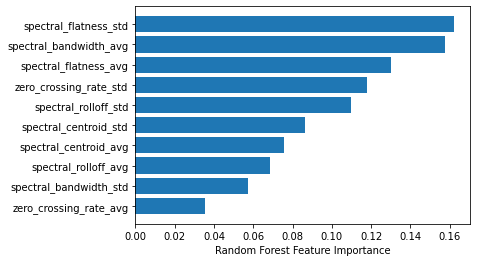

In [ ]:
sorted_idx = rfc2.feature_importances_.argsort()
feature_names = [f"feature {i}" for i in range(X.shape[1])]
plt.barh(X.columns[sorted_idx], rfc2.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

**Binary**

All features

In [ ]:
X = df.drop(['tds', 'tds_binary'], axis=1)
y = df.tds_binary # Target variable

oversample = SMOTE(k_neighbors=2)
X, y = oversample.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16)

In [ ]:
warnings.filterwarnings('ignore')

opt = BayesSearchCV(
    RandomForestClassifier(),
    {
        'n_estimators':  (100, 1000),
        'max_depth': (10, 100),
        'min_samples_split': np.linspace(0.0001, 1, 10), #add integers greater than 1
        'min_samples_leaf': np.linspace(0.0001, 0.5, 10), #add integers greater than 1
    },
    n_iter=32,
    scoring='f1_macro',
    cv=3
)

opt.fit(X_train, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))
print("best_params: %s" % opt.best_params_)

val. score: 0.9707909110955227
test score: 0.9832167832167833
best_params: OrderedDict([('max_depth', 10), ('min_samples_leaf', 0.0001), ('min_samples_split', 0.0001), ('n_estimators', 100)])


In [ ]:
rfc3 = RandomForestClassifier(n_estimators = opt.best_params_['n_estimators'], 
                             max_depth = opt.best_params_['max_depth'],
                             min_samples_split = opt.best_params_['min_samples_split'],
                             min_samples_leaf = opt.best_params_['min_samples_leaf'])
rfc3.fit(X_train, y_train)
y_pred = rfc3.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96        28
           1       0.94      1.00      0.97        32

    accuracy                           0.97        60
   macro avg       0.97      0.96      0.97        60
weighted avg       0.97      0.97      0.97        60



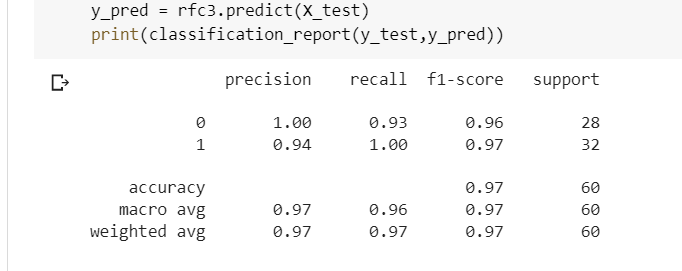

In [ ]:
kf = KFold(n_splits=10)

crossval_accuracy = cross_val_score(rfc3, X, y, scoring='accuracy', cv = kf)
mean_score = crossval_accuracy.mean()
std_score = crossval_accuracy.std()
print('accuracy', mean_score, '±', std_score)

crossval_recall = cross_val_score(rfc3, X, y, scoring='recall_macro', cv = kf)
mean_score = crossval_recall.mean()
std_score = crossval_recall.std()
print('recall', mean_score, '±', std_score)

accuracy 0.9633333333333333 ± 0.03480102169636849
recall 0.8715127377831552 ± 0.20091482604246358


Text(0.5, 0, 'Random Forest Feature Importance')

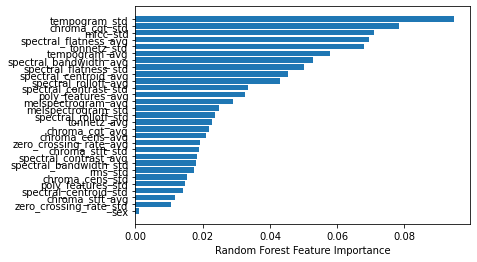

In [ ]:
sorted_idx = rfc3.feature_importances_.argsort()
feature_names = [f"feature {i}" for i in range(X.shape[1])]
plt.barh(X.columns[sorted_idx], rfc3.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

Only 1D features

In [ ]:
X = df1d.drop(['tds', 'tds_binary'], axis=1)
y = df1d.tds_binary # Target variable

oversample = SMOTE(k_neighbors=2)
X, y = oversample.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=16)

In [ ]:
warnings.filterwarnings('ignore')

opt = BayesSearchCV(
    RandomForestClassifier(),
    {
        'n_estimators':  (100, 1000),
        'max_depth': (10, 100),
        'min_samples_split': np.linspace(0.0001, 1, 10), #add integers greater than 1
        'min_samples_leaf': np.linspace(0.0001, 0.5, 10), #add integers greater than 1
    },
    n_iter=32,
    scoring='f1_macro',
    cv=3
)

opt.fit(X_train, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))
print("best_params: %s" % opt.best_params_)

val. score: 0.8662199654647402
test score: 0.9072447473824748
best_params: OrderedDict([('max_depth', 88), ('min_samples_leaf', 0.0001), ('min_samples_split', 0.0001), ('n_estimators', 1000)])


In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc4 = RandomForestClassifier(n_estimators = opt.best_params_['n_estimators'], 
                             max_depth = opt.best_params_['max_depth'],
                             min_samples_split = opt.best_params_['min_samples_split'],
                             min_samples_leaf = opt.best_params_['min_samples_leaf'])
rfc4.fit(X_train, y_train)
y_pred = rfc4.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.92      0.87      0.90        55
           1       0.90      0.94      0.92        65

    accuracy                           0.91       120
   macro avg       0.91      0.91      0.91       120
weighted avg       0.91      0.91      0.91       120



In [ ]:
kf = KFold(n_splits=10)

crossval_accuracy = cross_val_score(rfc4, X, y, scoring='accuracy', cv = kf)
mean_score = crossval_accuracy.mean()
std_score = crossval_accuracy.std()
print('accuracy', mean_score, '±', std_score)

crossval_recall = cross_val_score(rfc4, X, y, scoring='recall_macro', cv = kf)
mean_score = crossval_recall.mean()
std_score = crossval_recall.std()
print('recall', mean_score, '±', std_score)

accuracy 0.8933333333333333 ± 0.05537749241945382
recall 0.5763994451471766 ± 0.18303141940694378


Text(0.5, 0, 'Random Forest Feature Importance')

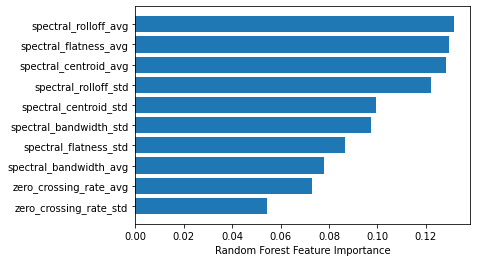

In [ ]:
sorted_idx = rfc4.feature_importances_.argsort()
feature_names = [f"feature {i}" for i in range(X.shape[1])]
plt.barh(X.columns[sorted_idx], rfc4.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")